In [32]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential
from keras.models import save_model, load_model
import requests
import zipfile
import tensorflow_text as tf_text
from sklearn.model_selection import train_test_split
from io import BytesIO

# Translator


## Tokenizers

In [33]:
text_file = pathlib.Path("ukr-eng.txt")

In [34]:
text = open(text_file, 'r', encoding='utf-8').read()

In [35]:
def cleaning(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    return text

In [36]:
def text_to_data(text):
    lines = text.split("\n")[:-1]
    e = []
    u = []
    for line in lines:
        eng, ukr, _ = line.split("\t")
        e.append(cleaning(eng))
        u.append(cleaning(ukr))
    return e, u

In [37]:
eng, ukr = text_to_data(text)

In [38]:
punct = string.punctuation
punct.replace('[', '')
punct.replace(']', '')

def standardization(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, "[%s]" % re.escape(punct), "")
    return tf.strings.join(['[START]', text, '[END]'], separator=' ')

In [39]:
num_words = 10000
sequence_length = 100
batch_size = 64
buffer_size = len(eng)

In [40]:
eng_vectorization = TextVectorization(max_tokens = num_words, output_mode="int",
                                      standardize=standardization #output_sequence_length=sequence_length
                                     )
ukr_vectorization = TextVectorization(max_tokens = num_words, output_mode="int",
                                      standardize=standardization #output_sequence_length=sequence_length
                                     )

In [41]:
eng_vectorization.adapt(eng)
ukr_vectorization.adapt(ukr)

In [42]:
vocab_ukr = np.array(ukr_vectorization.get_vocabulary())
vocab_eng = np.array(eng_vectorization.get_vocabulary())

In [43]:
print(vocab_ukr)

['' '[UNK]' '[START]' ... 'ледащо' 'ледачим' 'ледар']


In [44]:
x_train, x_test, y_train, y_test = train_test_split(eng, ukr, train_size=0.7)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5)

In [45]:
def vectorize_text(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (eng, ukr[:,:-1]),ukr[:,1:]

In [46]:
def make_dataset(eng, ukr):
    eng_texts = list(eng)
    spa_texts = list(ukr)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(vectorize_text)
    return dataset.shuffle(2048).prefetch(16).cache()

In [47]:
train_data = make_dataset(x_train, y_train)
test_data = make_dataset(x_test, y_test)
val_data = make_dataset(x_val,y_val)

## Attention layers

In [48]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [49]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [50]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [51]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

## The Encoder

In [52]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model

        self.embedding = Embedding(vocab_size, d_model)

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
        
        self.seq = Sequential([Dense(dff, activation='relu'),
                               Dropout(dropout_rate),
                               Dense(dff, activation='relu')])

        self.layer_norm = LayerNormalization()
        
      

    @tf.function
    def call(self, x):
        x = self.embedding(x)
 
        x = self.self_attention(x)
        x = self.seq(x)
        x = self.layer_norm(x)
        return x 

## The Decoder

In [53]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model

        self.embedding = Embedding(vocab_size, d_model)
        
        self.dropout = Dropout(dropout_rate)
        
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.seq = Sequential([Dense(dff, activation='relu'),
                               Dropout(dropout_rate),
                               Dense(dff, activation='relu')])

        self.layer_norm = LayerNormalization()

        self.last_attn_scores = None

    @tf.function
    def call(self, x, context):
        x = self.embedding(x)  

        x = self.cross_attention(x=x, context=context)

        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.seq(x)
        x = self.layer_norm(x)
        return x

## Translator

In [54]:
d_model = 128
dff = 128
num_heads = 8
dropout_rate = 0.1
embed_dim = 128

In [55]:
def acc_masked(y_true, y_pred):

    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [56]:
def loss_masked(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [57]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")

encoder_outputs = Encoder(d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=eng_vectorization.vocabulary_size(),
                           dropout_rate=dropout_rate)(encoder_inputs)
encoder = keras.Model(encoder_inputs, encoder_outputs)

In [58]:
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

x = Decoder(d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=ukr_vectorization.vocabulary_size(),
                           dropout_rate=dropout_rate)(decoder_inputs, encoded_seq_inputs)

decoder_outputs = layers.Dense(ukr_vectorization.vocabulary_size(), activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])


In [59]:
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [60]:
transformer.compile(optimizer='adam',
              loss=loss_masked, 
              metrics=[acc_masked, loss_masked])

In [61]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 encoder_1 (Encoder)            (None, None, 128)    1841024     ['encoder_inputs[0][0]']         
                                                                                                  
 model_3 (Functional)           (None, None, 10000)  3131024     ['decoder_inputs[0][0]',         
                                                                  'encoder_1[0][0]']    

In [62]:
transformer.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/20
1709/1709 [==============================] - 337s 196ms/step - loss: 4.4544 - acc_masked: 0.3409 - loss_masked: 4.4550 - val_loss: 3.3909 - val_acc_masked: 0.4394 - val_loss_masked: 3.3884
Epoch 2/20
1709/1709 [==============================] - 346s 202ms/step - loss: 2.8834 - acc_masked: 0.4804 - loss_masked: 2.8836 - val_loss: 2.6321 - val_acc_masked: 0.5061 - val_loss_masked: 2.6296
Epoch 3/20
1709/1709 [==============================] - 343s 201ms/step - loss: 2.2225 - acc_masked: 0.5416 - loss_masked: 2.2225 - val_loss: 2.3333 - val_acc_masked: 0.5366 - val_loss_masked: 2.3308
Epoch 4/20
1709/1709 [==============================] - 344s 202ms/step - loss: 1.8601 - acc_masked: 0.5828 - loss_masked: 1.8600 - val_loss: 2.1960 - val_acc_masked: 0.5545 - val_loss_masked: 2.1929
Epoch 5/20
1709/1709 [==============================] - 348s 204ms/step - loss: 1.6339 - acc_masked: 0.6136 - loss_masked: 1.6336 - val_loss: 2.1548 - val_acc_masked: 0.5634 - val_loss_masked: 2.1524


In [63]:
transformer.evaluate(test_data)

367/367 [==============================] - 35s 95ms/step - loss: 2.1952 - acc_masked: 0.5824 - loss_masked: 2.1963


[2.1951894760131836, 0.5823997259140015, 2.1963303089141846]

In [64]:
ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 40

In [65]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[START]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        
        
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ukr_index_lookup[sampled_token_index]

        decoded_sentence += " " + sampled_token

        if sampled_token == "[END]":
            break
    return decoded_sentence

In [66]:
def print_translation(sentence, translated_text, ground_truth):
    print("eng sentence:             " + sentence)
    print("translated ukr sentence:  " + translated_text)
    print("actually ukr sentence:    " + ground_truth)

In [67]:
sentence = 'i was here today'
ground_truth = 'я був тут сьогодні'

translated_text = decode_sequence(sentence)
print_translation(sentence, translated_text, ground_truth)

eng sentence:             i was here today
translated ukr sentence:  [START] сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут сьогодні сьогодні тут тут
actually ukr sentence:    я був тут сьогодні


In [68]:
sentence = 'hello my name is tom'
ground_truth = 'привіт моє імя том'

translated_text = decode_sequence(sentence)
print_translation(sentence, translated_text, ground_truth)

eng sentence:             hello my name is tom
translated ukr sentence:  [START] за ім безпеку я тома том прізвище — [END]
actually ukr sentence:    привіт моє імя том


In [69]:
sentence = 'good morning'
ground_truth = 'доброго ранку'

translated_text = decode_sequence(sentence)
print_translation(sentence, translated_text, ground_truth)

eng sentence:             good morning
translated ukr sentence:  [START] доброго [END]
actually ukr sentence:    доброго ранку


In [70]:
sentence = 'her condition got worse last night'
ground_truth = 'її стан погіршився вчора ввечері'

translated_text = decode_sequence(sentence)
print_translation(sentence, translated_text, ground_truth)

eng sentence:             her condition got worse last night
translated ukr sentence:  [START] лист [END]
actually ukr sentence:    її стан погіршився вчора ввечері


# Hugging face

In [71]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [72]:
txt_1 = 'My new computer is so fast and efficient'
classifier(txt_1)

[{'label': 'POSITIVE', 'score': 0.9997418522834778}]

In [73]:
txt_2 = 'My computer crashed and I lost all of my important files'
classifier(txt_2)

[{'label': 'NEGATIVE', 'score': 0.9997172951698303}]

In [74]:
txt_3 = 'The computer is a popular tool used in many workplaces'
classifier(txt_3)

[{'label': 'POSITIVE', 'score': 0.994707465171814}]

In [75]:
txt_4 = 'Computer viruses can cause irreparable damage to our systems'
classifier(txt_4)

[{'label': 'NEGATIVE', 'score': 0.9997434020042419}]

In [76]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

In [77]:
model_name = "ProsusAI/finbert"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model = model, tokenizer = tokenizer)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
txt_1 = 'My new computer is so fast and efficient'
classifier(txt_1)

[{'label': 'negative', 'score': 0.3681431710720062}]

In [79]:
txt_2 = 'My computer crashed and I lost all of my important files'
classifier(txt_2)

[{'label': 'neutral', 'score': 0.40116816759109497}]

In [80]:
txt_3 = 'The computer is a popular tool used in many workplaces'
classifier(txt_3)

[{'label': 'negative', 'score': 0.468403160572052}]

In [81]:
txt_4 = 'Computer viruses can cause irreparable damage to our systems'
classifier(txt_4)

[{'label': 'negative', 'score': 0.37754207849502563}]

In [82]:
inputs = tokenizer([txt_1, txt_2, txt_3, txt_4])
inputs

{'input_ids': [[101, 2026, 2047, 3274, 2003, 2061, 3435, 1998, 8114, 102], [101, 2026, 3274, 8007, 1998, 1045, 2439, 2035, 1997, 2026, 2590, 6764, 102], [101, 1996, 3274, 2003, 1037, 2759, 6994, 2109, 1999, 2116, 16165, 2015, 102], [101, 3274, 18191, 2064, 3426, 20868, 2890, 28689, 3468, 4053, 2000, 2256, 3001, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [83]:
tokens = tokenizer.tokenize(txt_4)
tokens

['computer',
 'viruses',
 'can',
 'cause',
 'ir',
 '##re',
 '##para',
 '##ble',
 'damage',
 'to',
 'our',
 'systems']

In [84]:
print(tokenizer.convert_tokens_to_ids(tokens))
print(tokenizer.decode(tokenizer.convert_tokens_to_ids(tokens)))

[3274, 18191, 2064, 3426, 20868, 2890, 28689, 3468, 4053, 2000, 2256, 3001]
computer viruses can cause irreparable damage to our systems


# Image Generation

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import os, sys

import requests
import keras

from keras.utils import get_file

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras import layers
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup, Activation, Input
from keras import Sequential
from keras.models import save_model, load_model

import tensorflow as tf

import tensorflow_text as tf_text

from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

import re
from PIL import Image, ImageDraw

In [86]:
from keras.layers.convolutional import UpSampling2D, Conv2D 
from keras.models import Sequential, Model 
from keras.optimizers import Adam,SGD 

In [87]:
save_path = 'img'

In [88]:
def load_images():
    x = []
    for i in range(1,711):
        if(i!=201):
            image = io.imread("pok\\" + str(i) + ".png")
            image = color.rgba2rgb(image)
            pad = np.full((40,40, 3), (1,1,1), dtype=np.float32)
            x_cen = 0
            y_cen = (10) // 2
            pad[y_cen:y_cen+30, x_cen:x_cen+40] = image
            pad = (pad - 1)*2
            x.append(pad)
    return x

In [89]:
X_train = load_images()
X_train=np.asarray(X_train)
print(X_train.shape)

(709, 40, 40, 3)


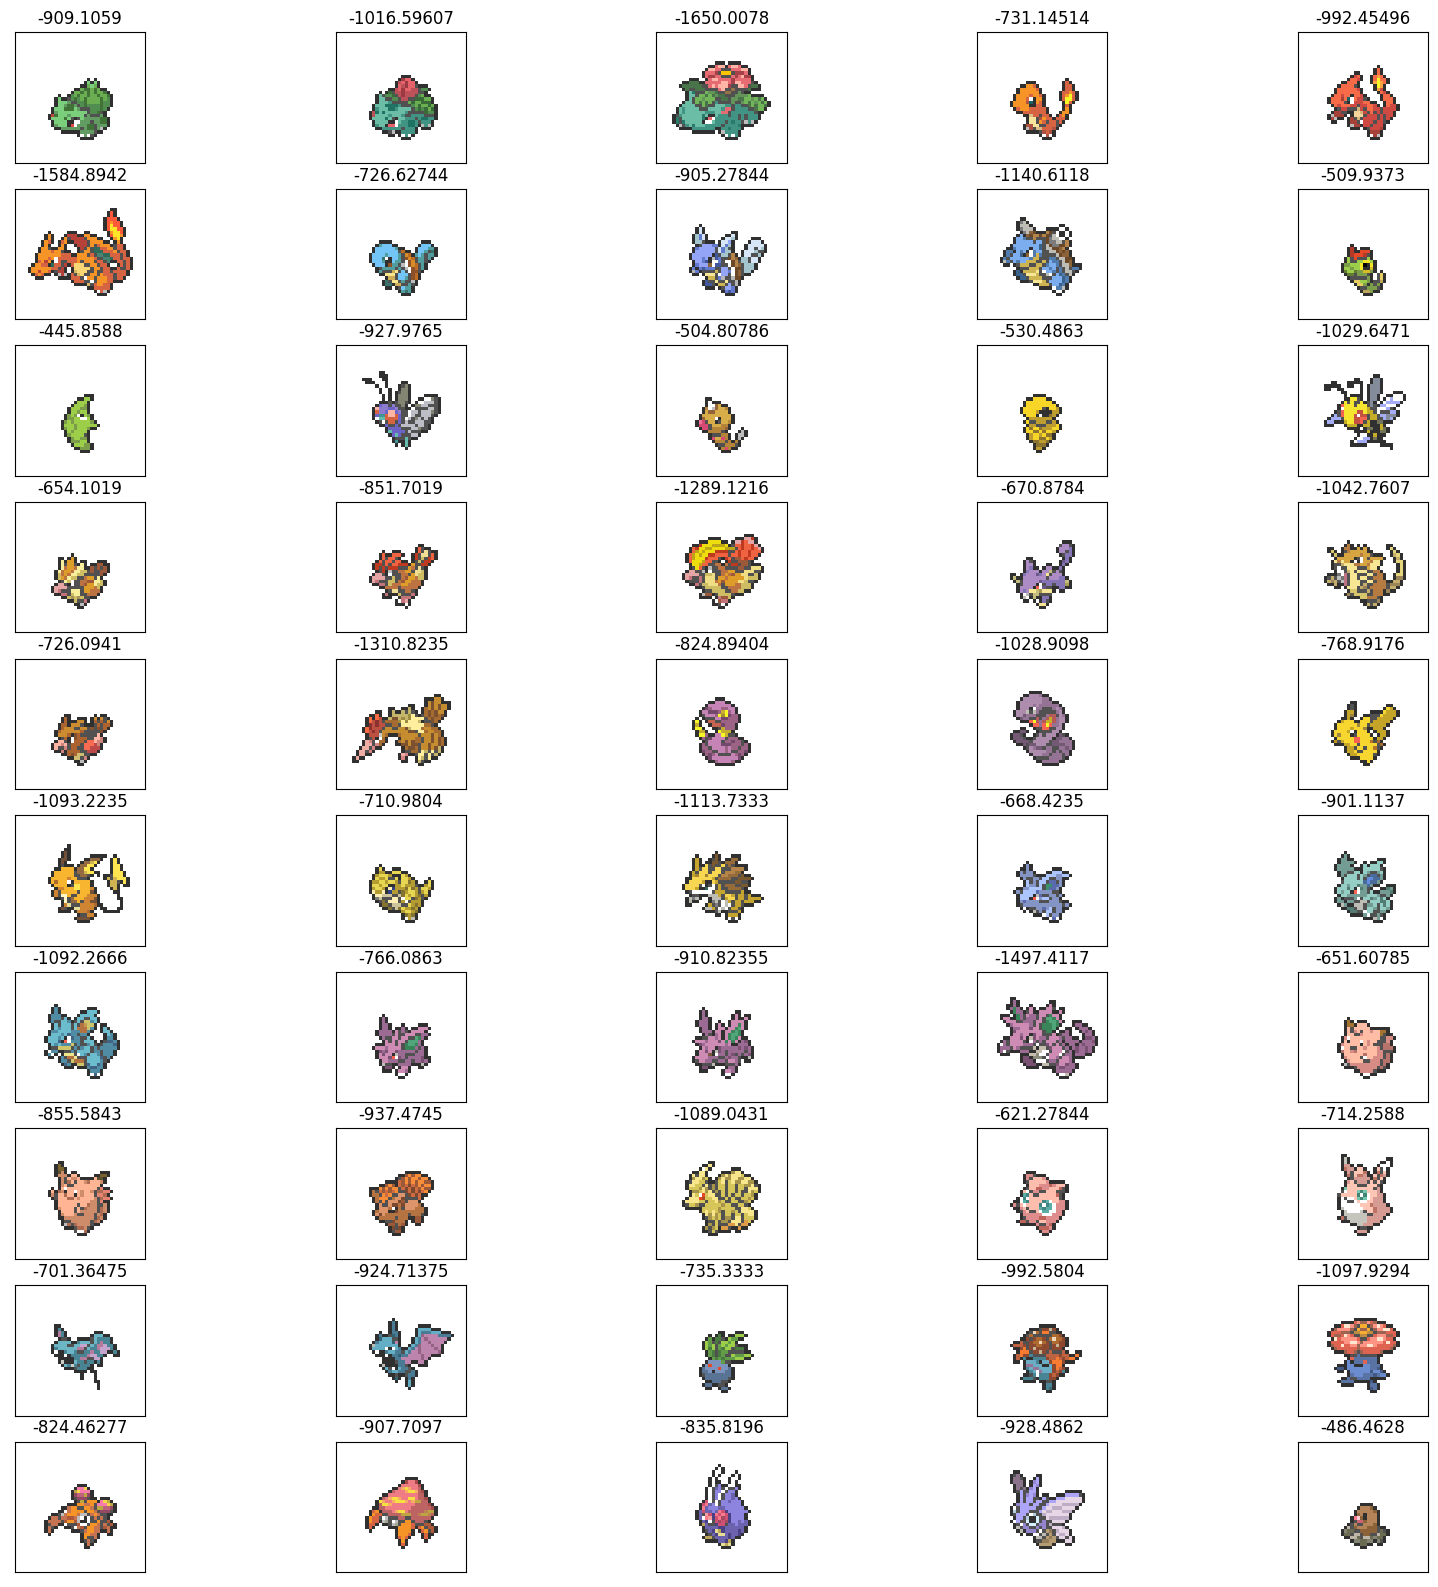

In [90]:
fig = plt.figure(figsize=(20,20))
for row in range(10):
    for column in range(5):
        i = row * 5 + column
        if i>len(X_train)-1:
            break                   
        ax = fig.add_subplot(10, 5, i+1)
        ax.set_title(str(np.sum(X_train[i])))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(X_train[i]/2 + 1)

In [91]:
optimiz = Adam(learning_rate=0.0002, beta_1=0.5)
optimiz_g = Adam(learning_rate=0.0001, beta_1=0.5)
dimension = 100

In [92]:
X_train = np.clip(X_train, -1, 1)

In [93]:
def build_generator(): 
	model = Sequential()
	n_nodes = 256 * 5 * 5
	model.add(Dense(n_nodes, input_dim=dimension))
	model.add(Reshape((5, 5, 256)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(UpSampling2D())
	model.add(Conv2D(128, 3, padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [94]:
def build_discriminator(optimiz):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", input_shape=(40, 40, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimiz, metrics=['accuracy'])
    return model

In [95]:
def display_images(epoch): 
        r, c = 5,5
        noise = np.random.normal(0, 1, (r * c,dimension)) 
        generated_images = generator.predict(noise) 
        
        #Scaling the generated images 
        generated_images = 0.5 * generated_images + 0.5
                    
        fig, axs = plt.subplots(r, c) 
        count = 0
        for i in range(r): 
            for j in range(c): 
                axs[i,j].imshow(generated_images[count, :,:,]) 
                axs[i,j].axis('off') 
                plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
                count += 1
        plt.show() 
        plt.close()


In [96]:
# Building and compiling the discriminator 
discriminator = build_discriminator(optimiz) 
discriminator.compile(loss='binary_crossentropy', 
					optimizer=Adam(0.0002,0.5), 
					metrics=['accuracy']) 

#Making the Discriminator untrainable 
#so that the generator can learn from fixed gradient 
discriminator.trainable = False

# Building the generator 
generator = build_generator() 

#Defining the input for the generator and generating the images 
dummy = Input(shape=(dimension,)) 
image = generator(dummy) 


#Checking the validity of the generated image 
valid = discriminator(image) 

#Defining the combined model of the Generator and the Discriminator 
combined_network = Model(dummy, valid) 
combined_network.compile(loss='binary_crossentropy', 
						optimizer=Adam(0.0002,0.5))

In [97]:
from keras.utils import plot_model
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6400)              646400    
                                                                 
 reshape (Reshape)           (None, 5, 5, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 128)      524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 10, 10, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 20, 20, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 20, 20, 128)      

In [98]:
from keras.utils import plot_model
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 40, 40, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 40, 40, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       147584    
                                                      

In [99]:
num_epochs=10000
batch_size=32
display_after=1000
losses=[] 

1/1 [==============================] - 0s 139ms/step
0
1/1 [==============================] - 0s 111ms/step


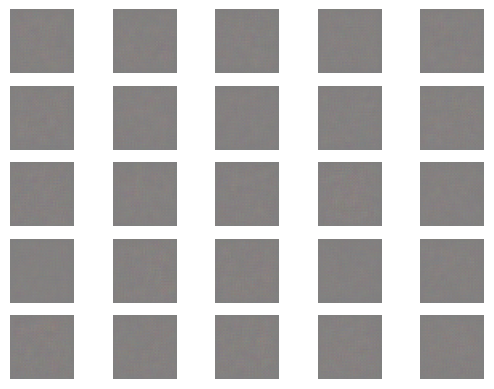

1/1 [==============================] - 0s 62ms/step
1
1/1 [==============================] - 0s 70ms/step
2
1/1 [==============================] - 0s 57ms/step
3
1/1 [==============================] - 0s 57ms/step
4
1/1 [==============================] - 0s 56ms/step
5
1/1 [==============================] - 0s 58ms/step
6
1/1 [==============================] - 0s 60ms/step
7
1/1 [==============================] - 0s 56ms/step
8
1/1 [==============================] - 0s 61ms/step
9
1/1 [==============================] - 0s 54ms/step
10
1/1 [==============================] - 0s 58ms/step
11
1/1 [==============================] - 0s 57ms/step
12
1/1 [==============================] - 0s 56ms/step
13
1/1 [==============================] - 0s 57ms/step
14
1/1 [==============================] - 0s 57ms/step
15
1/1 [==============================] - 0s 57ms/step
16
1/1 [==============================] - 0s 58ms/step
17
1/1 [==============================] - 0s 56ms/step
18
1/1 [==============

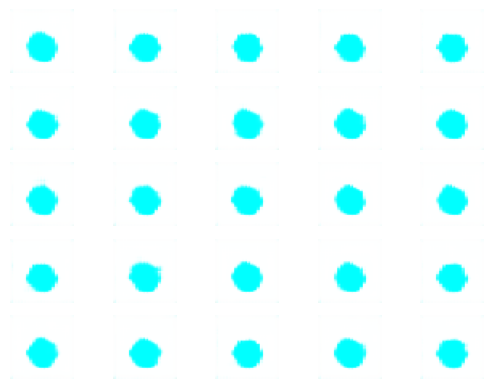

1/1 [==============================] - 0s 60ms/step
1001
1/1 [==============================] - 0s 60ms/step
1002
1/1 [==============================] - 0s 60ms/step
1003
1/1 [==============================] - 0s 56ms/step
1004
1/1 [==============================] - 0s 58ms/step
1005
1/1 [==============================] - 0s 56ms/step
1006
1/1 [==============================] - 0s 57ms/step
1007
1/1 [==============================] - 0s 58ms/step
1008
1/1 [==============================] - 0s 59ms/step
1009
1/1 [==============================] - 0s 57ms/step
1010
1/1 [==============================] - 0s 57ms/step
1011
1/1 [==============================] - 0s 58ms/step
1012
1/1 [==============================] - 0s 61ms/step
1013
1/1 [==============================] - 0s 56ms/step
1014
1/1 [==============================] - 0s 58ms/step
1015
1/1 [==============================] - 0s 59ms/step
1016
1/1 [==============================] - 0s 58ms/step
1017
1/1 [==========================

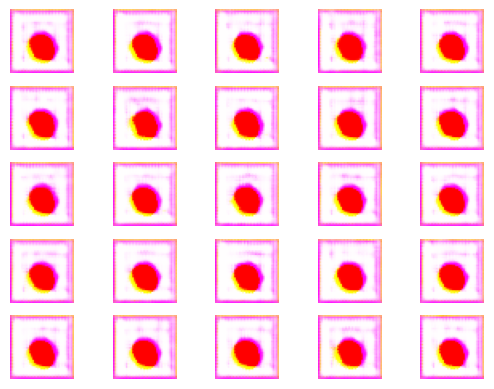

1/1 [==============================] - 0s 63ms/step
2001
1/1 [==============================] - 0s 57ms/step
2002
1/1 [==============================] - 0s 59ms/step
2003
1/1 [==============================] - 0s 56ms/step
2004
1/1 [==============================] - 0s 58ms/step
2005
1/1 [==============================] - 0s 57ms/step
2006
1/1 [==============================] - 0s 60ms/step
2007
1/1 [==============================] - 0s 58ms/step
2008
1/1 [==============================] - 0s 56ms/step
2009
1/1 [==============================] - 0s 58ms/step
2010
1/1 [==============================] - 0s 59ms/step
2011
1/1 [==============================] - 0s 58ms/step
2012
1/1 [==============================] - 0s 55ms/step
2013
1/1 [==============================] - 0s 59ms/step
2014
1/1 [==============================] - 0s 58ms/step
2015
1/1 [==============================] - 0s 57ms/step
2016
1/1 [==============================] - 0s 60ms/step
2017
1/1 [==========================

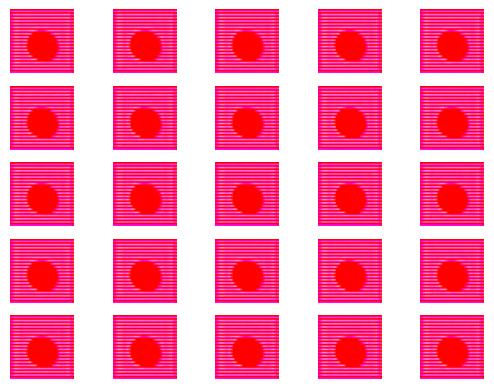

1/1 [==============================] - 0s 63ms/step
3001
1/1 [==============================] - 0s 58ms/step
3002
1/1 [==============================] - 0s 57ms/step
3003
1/1 [==============================] - 0s 58ms/step
3004
1/1 [==============================] - 0s 58ms/step
3005
1/1 [==============================] - 0s 58ms/step
3006
1/1 [==============================] - 0s 56ms/step
3007
1/1 [==============================] - 0s 59ms/step
3008
1/1 [==============================] - 0s 62ms/step
3009
1/1 [==============================] - 0s 60ms/step
3010
1/1 [==============================] - 0s 58ms/step
3011
1/1 [==============================] - 0s 56ms/step
3012
1/1 [==============================] - 0s 59ms/step
3013
1/1 [==============================] - 0s 59ms/step
3014
1/1 [==============================] - 0s 59ms/step
3015
1/1 [==============================] - 0s 58ms/step
3016
1/1 [==============================] - 0s 57ms/step
3017
1/1 [==========================

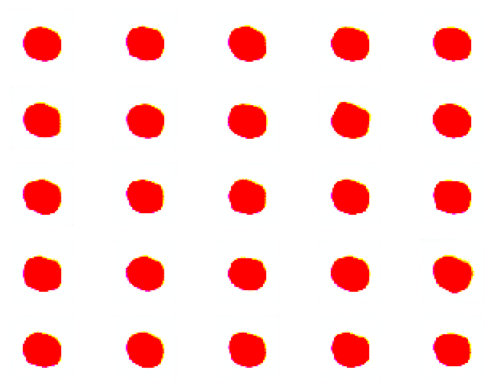

1/1 [==============================] - 0s 65ms/step
4001
1/1 [==============================] - 0s 55ms/step
4002
1/1 [==============================] - 0s 56ms/step
4003
1/1 [==============================] - 0s 55ms/step
4004
1/1 [==============================] - 0s 58ms/step
4005
1/1 [==============================] - 0s 58ms/step
4006
1/1 [==============================] - 0s 58ms/step
4007
1/1 [==============================] - 0s 56ms/step
4008
1/1 [==============================] - 0s 58ms/step
4009
1/1 [==============================] - 0s 71ms/step
4010
1/1 [==============================] - 0s 61ms/step
4011
1/1 [==============================] - 0s 57ms/step
4012
1/1 [==============================] - 0s 57ms/step
4013
1/1 [==============================] - 0s 56ms/step
4014
1/1 [==============================] - 0s 57ms/step
4015
1/1 [==============================] - 0s 56ms/step
4016
1/1 [==============================] - 0s 58ms/step
4017
1/1 [==========================

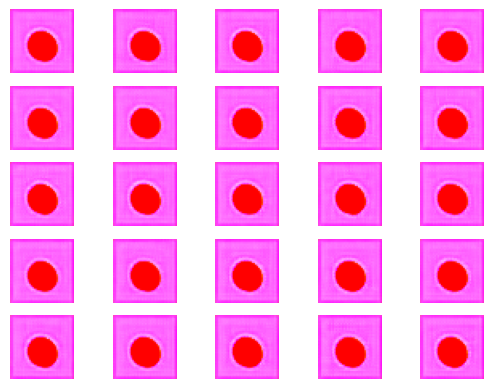

1/1 [==============================] - 0s 62ms/step
5001
1/1 [==============================] - 0s 57ms/step
5002
1/1 [==============================] - 0s 59ms/step
5003
1/1 [==============================] - 0s 63ms/step
5004
1/1 [==============================] - 0s 59ms/step
5005
1/1 [==============================] - 0s 57ms/step
5006
1/1 [==============================] - 0s 56ms/step
5007
1/1 [==============================] - 0s 59ms/step
5008
1/1 [==============================] - 0s 60ms/step
5009
1/1 [==============================] - 0s 62ms/step
5010
1/1 [==============================] - 0s 58ms/step
5011
1/1 [==============================] - 0s 58ms/step
5012
1/1 [==============================] - 0s 59ms/step
5013
1/1 [==============================] - 0s 62ms/step
5014
1/1 [==============================] - 0s 57ms/step
5015
1/1 [==============================] - 0s 57ms/step
5016
1/1 [==============================] - 0s 57ms/step
5017
1/1 [==========================

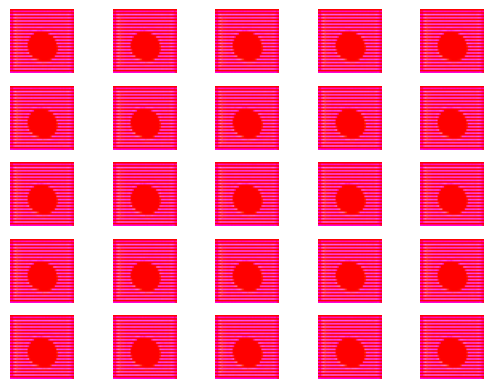

1/1 [==============================] - 0s 63ms/step
6001
1/1 [==============================] - 0s 60ms/step
6002
1/1 [==============================] - 0s 59ms/step
6003
1/1 [==============================] - 0s 56ms/step
6004
1/1 [==============================] - 0s 60ms/step
6005
1/1 [==============================] - 0s 57ms/step
6006
1/1 [==============================] - 0s 57ms/step
6007
1/1 [==============================] - 0s 59ms/step
6008
1/1 [==============================] - 0s 58ms/step
6009
1/1 [==============================] - 0s 60ms/step
6010
1/1 [==============================] - 0s 57ms/step
6011
1/1 [==============================] - 0s 59ms/step
6012
1/1 [==============================] - 0s 57ms/step
6013
1/1 [==============================] - 0s 69ms/step
6014
1/1 [==============================] - 0s 57ms/step
6015
1/1 [==============================] - 0s 57ms/step
6016
1/1 [==============================] - 0s 60ms/step
6017
1/1 [==========================

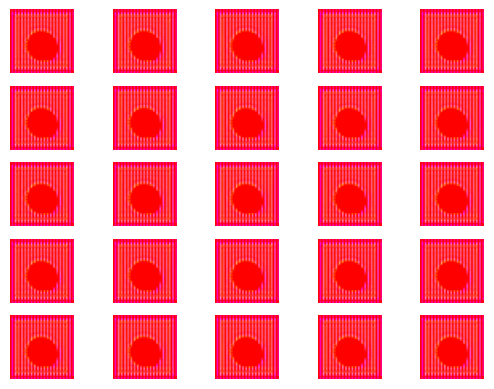

1/1 [==============================] - 0s 63ms/step
7001
1/1 [==============================] - 0s 56ms/step
7002
1/1 [==============================] - 0s 55ms/step
7003
1/1 [==============================] - 0s 57ms/step
7004
1/1 [==============================] - 0s 57ms/step
7005
1/1 [==============================] - 0s 56ms/step
7006
1/1 [==============================] - 0s 57ms/step
7007
1/1 [==============================] - 0s 56ms/step
7008
1/1 [==============================] - 0s 56ms/step
7009
1/1 [==============================] - 0s 58ms/step
7010
1/1 [==============================] - 0s 57ms/step
7011
1/1 [==============================] - 0s 57ms/step
7012
1/1 [==============================] - 0s 58ms/step
7013
1/1 [==============================] - 0s 57ms/step
7014
1/1 [==============================] - 0s 58ms/step
7015
1/1 [==============================] - 0s 56ms/step
7016
1/1 [==============================] - 0s 57ms/step
7017
1/1 [==========================

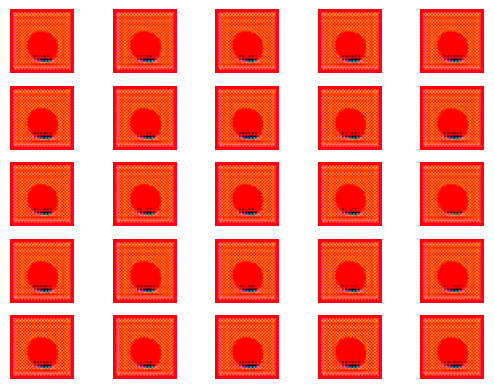

1/1 [==============================] - 0s 64ms/step
8001
1/1 [==============================] - 0s 58ms/step
8002
1/1 [==============================] - 0s 56ms/step
8003
1/1 [==============================] - 0s 56ms/step
8004
1/1 [==============================] - 0s 59ms/step
8005
1/1 [==============================] - 0s 58ms/step
8006
1/1 [==============================] - 0s 57ms/step
8007
1/1 [==============================] - 0s 56ms/step
8008
1/1 [==============================] - 0s 56ms/step
8009
1/1 [==============================] - 0s 61ms/step
8010
1/1 [==============================] - 0s 61ms/step
8011
1/1 [==============================] - 0s 58ms/step
8012
1/1 [==============================] - 0s 56ms/step
8013
1/1 [==============================] - 0s 59ms/step
8014
1/1 [==============================] - 0s 58ms/step
8015
1/1 [==============================] - 0s 62ms/step
8016
1/1 [==============================] - 0s 57ms/step
8017
1/1 [==========================

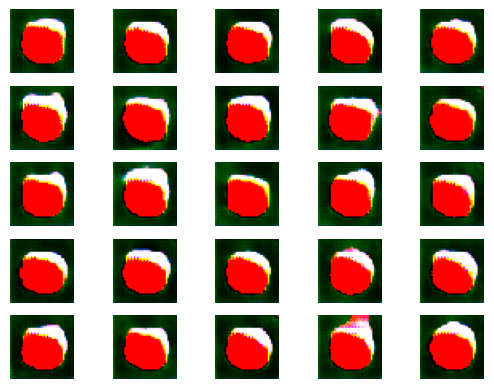

1/1 [==============================] - 0s 63ms/step
9001
1/1 [==============================] - 0s 60ms/step
9002
1/1 [==============================] - 0s 56ms/step
9003
1/1 [==============================] - 0s 56ms/step
9004
1/1 [==============================] - 0s 56ms/step
9005
1/1 [==============================] - 0s 57ms/step
9006
1/1 [==============================] - 0s 60ms/step
9007
1/1 [==============================] - 0s 57ms/step
9008
1/1 [==============================] - 0s 56ms/step
9009
1/1 [==============================] - 0s 56ms/step
9010
1/1 [==============================] - 0s 57ms/step
9011
1/1 [==============================] - 0s 59ms/step
9012
1/1 [==============================] - 0s 57ms/step
9013
1/1 [==============================] - 0s 57ms/step
9014
1/1 [==============================] - 0s 58ms/step
9015
1/1 [==============================] - 0s 58ms/step
9016
1/1 [==============================] - 0s 57ms/step
9017
1/1 [==========================

In [100]:
#Defining the Adversarial ground truths 
valid = np.ones((batch_size, 1)) 

#Adding some noise 
valid += 0.05 * np.random.random(valid.shape) 
fake = np.zeros((batch_size, 1)) 
fake += 0.05 * np.random.random(fake.shape) 

for epoch in range(num_epochs):
  # Training the Discriminator
  # Sampling a random half of images
  index = np.random.randint(0, X_train.shape[0], batch_size) 
  images = X_train[index]
  #Sampling noise and generating a batch of new images 
  noise = np.random.normal(0, 1, (batch_size, dimension)) 
  generated_images = generator.predict(noise) 
  # Training the discriminator to detect more accurately 
  # whether a generated image is real or fake 
  discm_loss_real = discriminator.train_on_batch(images, valid) 
  discm_loss_fake = discriminator.train_on_batch(generated_images, fake) 
  discm_loss = 0.5 * np.add(discm_loss_real, discm_loss_fake) 
  # Training the Generator 
  # Training the generator to generate images 
  # which pass the authenticity test 
  genr_loss = combined_network.train_on_batch(noise, valid) 
  # Tracking the progress
  print(epoch)
  if epoch % display_after == 0:
    display_images(epoch)

In [101]:
def func(x):
  for i in x:
    if(i.isdigit()):
      return int(i)
  return 10000000000

image_names = os.listdir(save_path)

frames = []
for image in sorted(image_names, key=func):
    if(bool(re.search(r'\d', image))):
        frames.append(Image.open(save_path + '/' + image))
frames[0].save('reconstruction_process.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)